## 1. Preparing the workspace.

Load necessary packages.

In [1]:
## topoflow
import topoflow
# short name alias to initiate TopoFlow run
topo_run = topoflow.topoflow.framework.tests.test_framework.topoflow_test
#NumPy for decimal ranges
import numpy as np
#SciPy for evaluating Gamma function
import scipy as sp
#os and errno for creating output directories
import os
import errno
from shutil import copyfile
#plotting functions
import matplotlib.pyplot as plt
#for text wrap of long titles
from textwrap import wrap
#datetime to check data availability
import datetime
#Pandas for data frames and data manipulation
import pandas as pd

#this line is necessary for plotting in iPython notebook
%matplotlib inline

Importing TopoFlow packages:
   topoflow.utils
   topoflow.utils.tests
   topoflow.components
   topoflow.components.tests
   topoflow.framework
   topoflow.framework.tests
   topoflow.gui (unfinished)
 
 
Paths for this package:
framework_dir = C:\Users\mericonritmo\Anaconda2\lib\site-packages\topoflow-3.4-py2.7.egg\topoflow\framework\
parent_dir    = C:\Users\mericonritmo\Anaconda2\lib\site-packages\topoflow-3.4-py2.7.egg\topoflow\
examples_dir  = C:\Users\mericonritmo\Anaconda2\lib\site-packages\topoflow-3.4-py2.7.egg\topoflow\examples\
__file__      = C:\Users\mericonritmo\Anaconda2\lib\site-packages\topoflow-3.4-py2.7.egg\topoflow\framework\emeli.pyc
__name__      = topoflow.framework.emeli
 


Set up the directory paths:

In [2]:
#### Set directory paths, our output path is absolute at the moment, you will need to change this to your outputpath
input_path = 'topoflow_input_files/'
channels_filename = 'channels_kinematic_wave.cfg'
infil_filename = 'infil_green_ampt.cfg'
topodriver_filename = 'topoflow.cfg'
meteorology_filename = 'meteorology.cfg'
base_components = [channels_filename, topodriver_filename, meteorology_filename]
output_path = '/cygwin64/home/mericonritmo/Documents/Python/topoflow_output_files/'

Define a function to create directories for output files as needed:

In [4]:
def create_path(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

This is a function we will need to set the output path in the enabled configuration files.

In [5]:
def create_cfg(filename,run):
    f = open(input_path+filename,'r')
    info = f.read()
    f.close()
    info = info.replace('~/TopoFlow_Runs/Caribou/C2',run)
    f = open(input_path+'Test1_'+filename,'w')
    f.write(info)
    f.close()

This function will create the infiltration input file by plugging in the desired parameter values.

In [6]:
def create_infil_cfg(infil_filename,run,Ksat,theta_i,G):
    f = open(input_path+infil_filename,'r')
    info = f.read()
    f.close()
    
    #theta_e and Ki computed from theta_i, theta_sat, Ksat
    theta_e = theta_i/theta_sat
    Ki = Ksat*theta_e**(eta/lambda_table)
    info=info.replace('~/TopoFlow_Runs/Caribou/C2',run)
    info=info.replace('Ks[0]               | 1e-06       | ',\
        'Ks[0]               | '+str(Ksat)+'       | ')
    info=info.replace('Ki[0]               | 7.15e-7         ',\
        'Ki[0]               | '+str(Ki)+'         ')
    info=info.replace('qi[0]               | 0.205     ',\
        'qi[0]               | '+str(theta_i)+'     ')
    info=info.replace('G[0]                | 0.724         ',\
        'G[0]                | '+str(G)+'         ')
    
    f = open(input_path+'Test1_'+infil_filename,'w')
    f.write(info)
    f.close()

This function will disable the infiltration component.

In [7]:
def disable_infil_cfg(infil_filename):
    f = open(input_path+infil_filename,'r')
    info = f.read()
    f.close()
            
    info=info.replace('Enabled','Disabled')
    
    f = open(input_path+'Test1_'+infil_filename,'w')
    f.write(info)
    f.close()

The following function cleans up after a run -- it deletes unwanted files and copies over the infiltration cfg to help keep track of the parameter settings for the run.

In [8]:
def post_run_cleanup(run):
    try:
        os.remove(run+'/Test1_0D-Q.nc')
    except:
        print 'Test1_0D-Q_1.nc not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.bov')
    except:
        print 'Test1_2D-Q_1.bov not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.nc')
    except:
        print 'Test1_2D-Q_1.nc not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.rti')
    except:
        print 'Test1_2D-Q_1.rti not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.rts')
    except:
        print 'Test1_2D-Q_1.rts not removed!'
    copyfile(input_path+'Test1_'+infil_filename,\
                run+'/Test1_'+infil_filename)

This function creates and displays a plot of measured and computed discharge.

In [9]:
def plot_discharge_comparison(run):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)

    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,flow_data['Flow']*.001, 'g-')
    ax2.plot(temp[0]/60/24,temp[1], 'b-')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('observed discharge rate (m$^3$/s)', color='g')
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='b')
    plt.title("\n".join(wrap('C2 observed and computed discharges', 60)))
    plt.show()

This function plots multiple discharge curves.

In [42]:
def plot_discharge_comparison_multiple(path,runs,x_range=None,y_range=None):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    if x_range is None:
        ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,flow_data['Flow']*.001, 'k-',label='observed')
        ax1.set_ylabel('observed discharge rate (m$^3$/s)', color='k')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')

    ax2 = ax1.twinx()
    if not(x_range is None):
        ax2.set_xticks(x_range)
    if not(y_range is None):
        ax2.set_yticks(y_range)
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        ax2.plot(temp[0]/60/24,temp[1],color_cycle[x%4]+line_cycle[x/4],label=runs[x])
        ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='k')
    if not (x_range is None):
        plt.xlim([min(x_range),max(x_range)])
    if not (y_range is None):
        plt.ylim([min(y_range),max(y_range)])
    plt.title("\n".join(wrap('C2 observed and computed discharges', 60)))
    plt.legend()
    plt.show()

This function creates and displays a plot of measured and computed cumulative discharge.

In [11]:
def plot_cumulative_discharge_comparison(run):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)

    baseflow = 0.037 #m3/s
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y

    # plot the cumulative discharges
    int_obs_discharge = int_fun(flow_data['Flow']*.001-baseflow,15*60)
    int_comp_discharge = int_fun(temp[1],60)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,\
        int_obs_discharge, 'g-')
    ax2.plot(temp[0]/60/24,int_comp_discharge, 'b-')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative observed discharge (m$^3$)', color='g')
    ax2.set_ylabel('cumulative computed discharge (m$^3$)', color='b')
    plt.title("\n".join(wrap('C2 volumetric precipitation and computed discharges', 60)))
    plt.show()

This function plots the computed discharge alongside the precipiation peaks.

In [12]:
def plot_precip_discharge_comparison(run):
    try:
        precip_data = pd.read_csv('precipitation/precip_cpeak_slice.csv')
    except:
        print 'File not present. Please put precip_cpeak_slice.csv in precipitation folder.'
        return
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(precip_data['time-seconds']/3600/24-time_min/3600/24,\
        precip_data['cpeak_value']*4.83503*10**3/3600, 'g-')
    ax2.plot(temp[0]/60/24,temp[1], 'b-')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('volumetric precipitation rate (m$^3$/s)', color='g')
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='b')
    plt.title("\n".join(wrap('C2 volumetric precipitation and computed discharges', 60)))
    plt.show()

This function plots the area under the plots (cumulative total discharge) as a function of a parameter (G).

In [13]:
def plot_total_discharge(path,runs):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    baseflow = 0.037 #m3/s
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y

    int_obs_discharge = int_fun(flow_data['Flow']*.001-baseflow,15*60)
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,\
        int_obs_discharge, 'k-',label='observed')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative observed discharge (m$^3$)', color='k')
    ax2 = ax1.twinx()
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        int_comp_discharge = int_fun(temp[1],60)
        ax2.plot(temp[0]/60/24,int_comp_discharge,color_cycle[x%4]+line_cycle[x/4],label=runs[x])
        ax2.set_ylabel('cumulative computed discharge (m$^3$)', color='k')
    plt.title("\n".join(wrap('C2 cumulative observed and computed discharges', 60)))
    plt.legend()
    plt.show()

## 2. Set up parameter inputs.

These are the parameters needed for the infiltration process.

In [3]:
lambda_table = 0.189
G_table = 0.724 # m, cappilary length scale from table
theta_sat = 0.205 # saturated water content
psi_B = -0.786 # m, bubbling pressure head
eta = 2+3*lambda_table
c = eta/lambda_table
f1 = 1+1/c
f2 = (eta-1)/c
# m, capillary length scale, transitional Brooks-Corey
# G_tBC = -psi_B*sp.special.gamma(f1)*sp.special.gamma(f2)/sp.special.gamma(lambda_table) 
# special not working at the moment, so here is the value
G_tBC = 1.271863334375879

# These are the values that we will play around with, but for now we initialize them:
G = G_table #m
Ksat = 5*10**-7 #m/s
theta_i = 0.18

#### Set start and end times for desired data chunk
time_min=(datetime.datetime.strptime('2008/07/28  16:00:00',\
    '%Y/%m/%d %H:%M:%S')-datetime.datetime(1970,1,1)).total_seconds()

## 3. Run TopoFlow

### Run 1. No infiltration.

For the first run, we will turn on the meteorology, topoflow, and kinematic wave components. The meteorology component will take precipitation as an input.

First, we need to create the input files.

In [14]:
run='no_infiltration'
create_path(output_path+run)
for filename in base_components:
    create_cfg(filename,output_path+run)

For this run only, we need to disable the infiltration component.

In [15]:
disable_infil_cfg(infil_filename)

Now we run the simulation. If you would like to execute this step, take out the comment on the next two lines. Run time on a typical machine is about 10-20 minutes. 

In [18]:
%%capture
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)

In [19]:
#post_run_cleanup(output_path+run)

Let's visualize what we just ran.

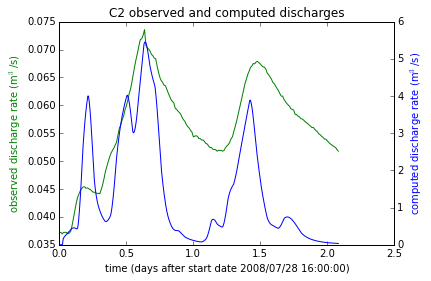

In [20]:
plot_discharge_comparison(output_path+run)

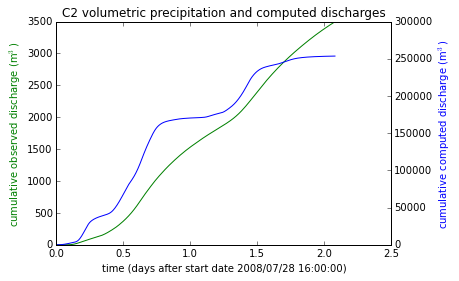

In [21]:
plot_cumulative_discharge_comparison(output_path+run)

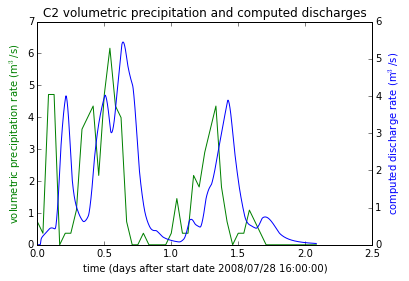

In [22]:
plot_precip_discharge_comparison(output_path+run)

Also, let's look at the log file which gives us a summary of the run, including the total precipitation volume as well as the total discharge volume.

In [23]:
with open(output_path+run+'/Test1.log', 'r') as fin:
    print fin.read()


TopoFlow Version 3.4 beta (9/22/14)
Wed Oct 26 11:38:16 2016

Input directory:      C:\cygwin64\home\mericonritmo\Documents\Python\topoflow_input_files\
Output directory:     /cygwin64/home/mericonritmo/Documents/Python/topoflow_output_files/no_infiltration\
Site prefix:          C2
Case prefix:          Test1

Simulated time:      3000.0 [min]
Program run time:    19.0538333337 [min]

Number of timesteps: 90000
Number of columns:   233
Number of rows:      113

T_stop:            3000.0 [min]

Main Outlet ID:    (101, 124)(row, col)
Basin_area:        4.83503 [km^2]

Min Manning's n:   0.0131894815713
Max Manning's n:   0.300035893917
Min z0 value:      -1.0 [m]
Max z0 value:      -1.0 [m]

Q_final:           0.0355085383825 [m^3/s]
Q_peak:            5.45103567154 [m^3/s]
T_peak:            921.2 [min]
u_peak:            3.93071142742 [m/s]
Tu_peak:           921.166666667 [min]
d_peak:            0.213512082627 [m]
Td_peak:           921.166666667 [min]

Max(precip rate):  4.590000

From the output file above, we see that at the end of the simulation, there is still a large volume of water (~300000 m^3) that has not drained out and is ponding in the watershed. We also see that the discharge curve mirrors the precipitation curve. From the discharge comparison plot, we note the following: (a) the response to the second and third precipitation peaks blend together so that the second peak becomes a shoulder of the third peak in the observations, (b) the precipitation response and discharge decay rate the the simulation are much more rapid than the observed, and (c) if we name the peaks A, B, and C, where A is the discharge response to the first precipitation peak, B is the combined response to the second and third precipitation peaks, and C is the response to the last precipitation peak, then the ratio of peak A to peak B is much smaller in the observed versus the simulated response, while the ratio of peak C to B is approximately 3.5/5 in the simulation and 1/2 in the observed data. Therefore, attenuation is most significant for the first peak, followed by the last peak.

### Run2. Maximum infiltration.

Now, let's turn on infiltration and do a run with a high Ks that is higher than the highest precipitation rate and will thus supress all of the peaks. Again, to actually run this part, take out the comments from the lines below.

In [25]:
run='max_infiltration'
create_path(output_path+run)
for filename in base_components:
    create_cfg(filename,output_path+run)
create_infil_cfg(infil_filename,run,Ksat=1.5e-6,theta_i=theta_sat,G=G)

In [26]:
%%capture
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)

In [27]:
#post_run_cleanup(output_path+run)

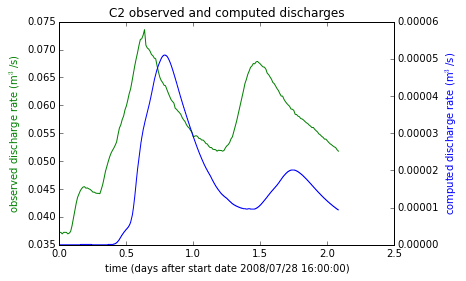

In [28]:
plot_discharge_comparison(output_path+run)

In [29]:
with open(output_path+run+'/Test1.log', 'r') as fin:
    print fin.read()


TopoFlow Version 3.4 beta (9/22/14)
Wed Oct 26 13:11:35 2016

Input directory:      C:\cygwin64\home\mericonritmo\Documents\Python\topoflow_input_files\
Output directory:     /cygwin64/home/mericonritmo/Documents/Python/topoflow_output_files/max_infiltration\
Site prefix:          C2
Case prefix:          Test1

Simulated time:      3000.0 [min]
Program run time:    17.0546000004 [min]

Number of timesteps: 90000
Number of columns:   233
Number of rows:      113

T_stop:            3000.0 [min]

Main Outlet ID:    (101, 124)(row, col)
Basin_area:        4.83503 [km^2]

Min Manning's n:   0.0131894815713
Max Manning's n:   0.300035893917
Min z0 value:      -1.0 [m]
Max z0 value:      -1.0 [m]

Q_final:           9.33355564172e-06 [m^3/s]
Q_peak:            5.10065425862e-05 [m^3/s]
T_peak:            1131.36666667 [min]
u_peak:            0.0392632697548 [m/s]
Tu_peak:           1131.33333333 [min]
d_peak:            0.000200101151804 [m]
Td_peak:           1131.33333333 [min]

Max(pre

For this runs, we note that the infiltrated volume (vol_IN) is higher than the precipitated volume; this is most likely due to an error from the discretized, computational solution. We see that essentially all of the volume is infiltrated, and no more ponding occurs, as expected.

### Run 3. Saturated soil, sweep Ks.

For this run, we start with completely saturated soil and observe the modulation effect of Ks on the peak responses. From the Green-Ampt equation, we expect this result to affect peaks independent of when they occur, as the f_c component is null (theta_i = theta_sat).

Again, take out comments below to run the model. (This run may take up to several hours.)

In [30]:
%%capture
run='Ks_sweep_at_saturation/'
runname = ['Ks5en7','Ks5p5en7','Ks6en7','Ks6p5en7','Ks7en7','Ks7p5en7','Ks8en7','Ks8p5en7']
create_path(output_path+run)
for x in range(8): #8 Ks runs with theta_i = theta_sat
    Ksat = 5.0*10**-7 + 0.5*x*10**-7
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=theta_sat,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

Now we plot the Ks sweep to see how Ks affects the discharge output.

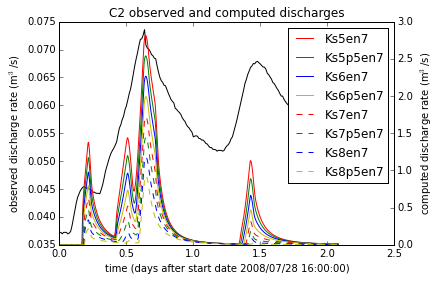

In [31]:
plot_discharge_comparison_multiple(output_path+run,runname)

We note that Ks alone has the greatest attenuation impact on the small peak of the peak B pair, and on peak C. This follows from the fact that, from the precipitation plot, these responses correspond to the two smallest precipitation peaks. To get a better look, let's zoom in on the first two peaks and note how the ratio of the height of peak A to the small peak of the peak B pair increases with increasing Ks. 

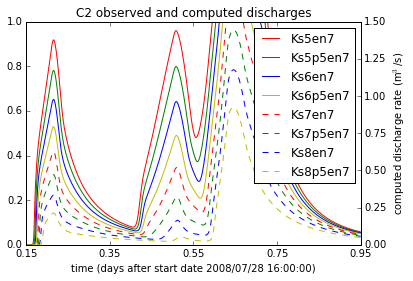

In [43]:
plot_discharge_comparison_multiple(output_path+run,runname,x_range=np.arange(0.15,1,0.2),y_range=np.arange(0,1.51,0.25))

### Run 4. Test the effect of G on peaks for constant Ks.

Now, let's do a sweep run testing the effect of G on the peaks. We expect that the first few peaks will be more affected, and that as we increase G, the effect will be more emphasized.

Again, take out commented lines below if you would like to run these simulations. The run may take up to 2 hours.

In [44]:
%%capture
run='G_sweep_for_peaks/'
Ksat = 7*10**-7 #m/s
runname = ['G0p012','G0p01','G0p008','G0p006','G0p004']
create_path(output_path+run)
for x in range(5): #5 runs with theta_i = 0.01
    G = 0.012 - 0.002*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.01,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

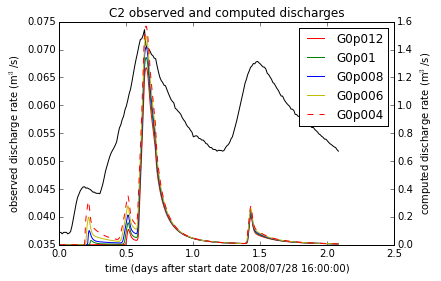

In [45]:
plot_discharge_comparison_multiple(output_path+run,runname)

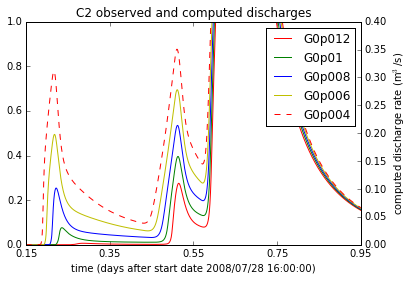

In [46]:
plot_discharge_comparison_multiple(output_path+run,runname,x_range=np.arange(0.15,1,0.2),y_range=np.arange(0,0.42,0.05))

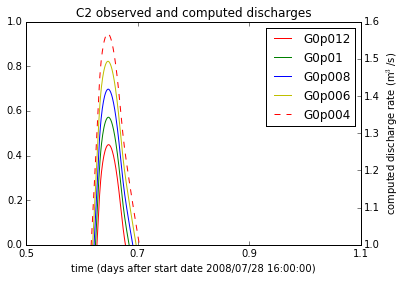

In [50]:
plot_discharge_comparison_multiple(output_path+run,runname,x_range=np.arange(0.5,1.1,0.2),y_range=np.arange(1,1.6,0.1))

The peaks comprising A and B are significantly affected by G, while the last peak is not.

In order to maximize infiltration while retaining the peaks, we try to keep theta_i small and increase G until the first two peaks start to disappear. This will give us the minimum volume discharge we can obtain with this Ks setting while retaining the peaks. This procedure yields us the optimum product G(theta_sat-theta_i)(1-(theta_i/theta_sat)^c). We may then adjust theta_i and G so that they are within a reasonable range. 

### Run 5. Example of matching total volume discharge but not necessarily peaks.

In [52]:
%%capture
run='G_sweep_for_area/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p725','G0p675','G0p625','G0p575','G0p525']
create_path(output_path+run)
for x in range(5): #5 runs with theta_i = 0.17
    G = 0.725 - 0.05*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

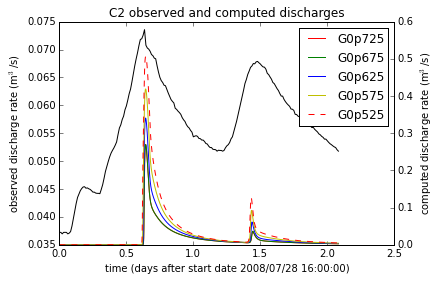

In [53]:
plot_discharge_comparison_multiple(output_path+run,runname)

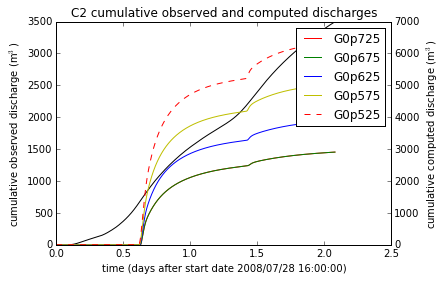

In [54]:
plot_total_discharge(output_path+run,runname)

### Run 6. Example of maintaining peaks while minimizing volume (with volume still large).

In [55]:
%%capture
run='maintaining_peaks_low_volume/'
Ksat = 7.9*10**-7 #m/s
runname = ['G0p005','G0p006']
create_path(output_path+run)
for x in range(2): #2 runs with theta_i = 0.01
    G = 0.005 + 0.001*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.01,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

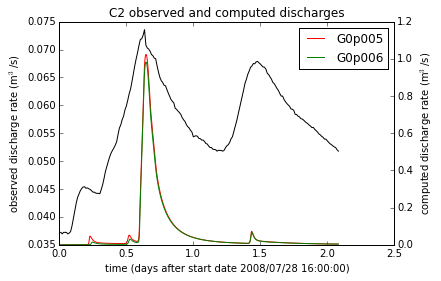

In [56]:
plot_discharge_comparison_multiple(output_path+run,runname)

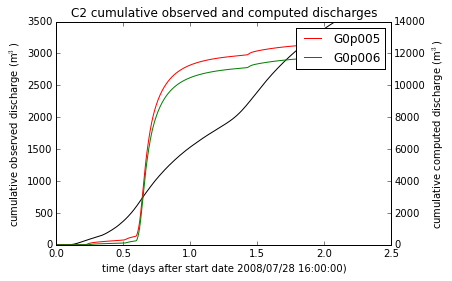

In [57]:
plot_total_discharge(output_path+run,runname)

### Run 7. Example of maintaining peaks, but volume is much larger than measured.

In [58]:
%%capture
run='maintaining_peaks_high_volume/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p1']
create_path(output_path+run)
G = 0.1
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

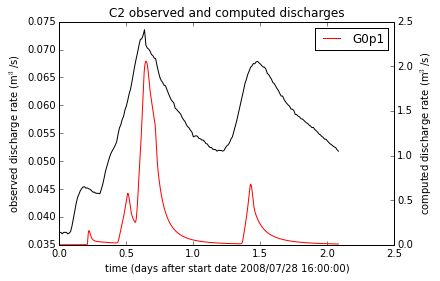

In [59]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [60]:
%%capture
run='maintaining_peaks_high_volume/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p082']
create_path(output_path+run)
G = 0.082
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.18,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

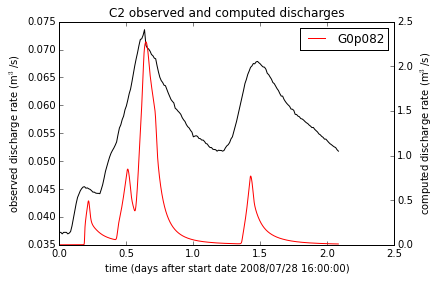

In [61]:
plot_discharge_comparison_multiple(output_path+run,runname)

### Run 8. Example effects of vegetation/surface drag.
For the following runs, the drag/roughness was increased by multiplying the Manning n grid by a factor. You will have to change either the input files in TopoFlow or the factor in the code before running.

Drag factor = 5:

In [62]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_5/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p1']
create_path(output_path+run)
G = 0.1
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

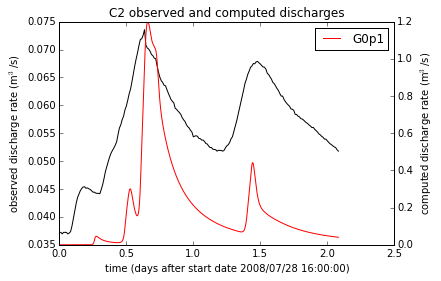

In [63]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [64]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_15/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p1']
create_path(output_path+run)
G = 0.1
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

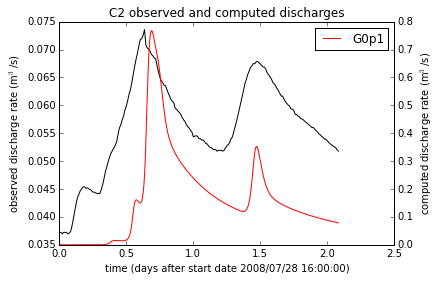

In [65]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [66]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_15/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p082']
create_path(output_path+run)
G = 0.082
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.18,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

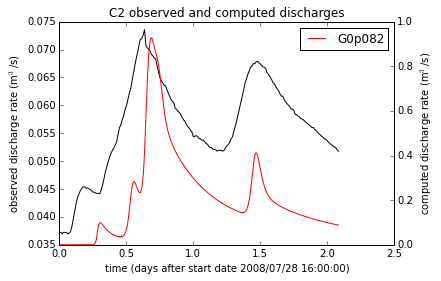

In [67]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [68]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_30/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p082']
create_path(output_path+run)
G = 0.082
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.18,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

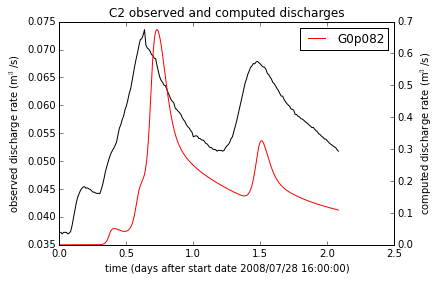

In [69]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [70]:
with open(sub_run+'/Test1.log', 'r') as fin:
    print fin.read()


TopoFlow Version 3.4 beta (9/22/14)
Thu Oct 27 18:48:50 2016

Input directory:      C:\cygwin64\home\mericonritmo\Documents\Python\topoflow_input_files\
Output directory:     /cygwin64/home/mericonritmo/Documents/Python/topoflow_output_files/maintaining_peaks_high_volume/drag_factor_30/G0p082\
Site prefix:          C2
Case prefix:          Test1

Simulated time:      3000.0 [min]
Program run time:    20.1153999964 [min]

Number of timesteps: 90000
Number of columns:   233
Number of rows:      113

T_stop:            3000.0 [min]

Main Outlet ID:    (101, 124)(row, col)
Basin_area:        4.83503 [km^2]

Min Manning's n:   0.395684450865
Max Manning's n:   9.0010766983
Min z0 value:      -1.0 [m]
Max z0 value:      -1.0 [m]

Q_final:           0.108835394001 [m^3/s]
Q_peak:            0.67493210016 [m^3/s]
T_peak:            1048.3 [min]
u_peak:            0.214915637918 [m/s]
Tu_peak:           1048.26666667 [min]
d_peak:            0.483236237466 [m]
Td_peak:           1048.26666667 

Although the volume and timing are off, we note that increasing the drag gives us curves that much more closely resemble the observed output. The timing of the peaks is off because we have to increase the drag factor to extremely high values; this is necessitated by the high volumes. Therefore, we conclude that surface resistance has a great impact on the character of the outflow.

There are many reasons why the simulations are not able to obtain simultaneously an accurate curve shape retaining all of the peaks and a correct volume. Among these reasons, the predominant factor is likely that precipitation data is sparse (collected hourly) and thus may not reflect the true oscillations of the precipitation, forcing us to model using lower Ks values than those of the real system.